In [1]:
# Author: Jacob Hunt

# A university assignment wherein I attempt to find the best predictors of 
# wheat grains with desirable nutritional content. 


In [2]:
wheat <- read.csv("wheat.txt")

In [3]:
t.wheat = t(wheat)
s.wheat = scale(wheat)
s.t.wheat = t(s.wheat)

In [4]:

# In the plot below, darker blue values correspond to samples with higher water values
# and more nutritious wheat samples.
# We can see that all samples' transmittance splines follow a similair shape and that 
# samples with higher water values tend to reflect this shape, but are apparently shifted to lower 
# infrared frequencies, and with some apparent changes in spline shape itself in the X20 to X50 range. 

# Samples are scaled and centered  

library(pls)

attach(wheat)


Attaching package: ‘pls’


The following object is masked from ‘package:stats’:

    loadings




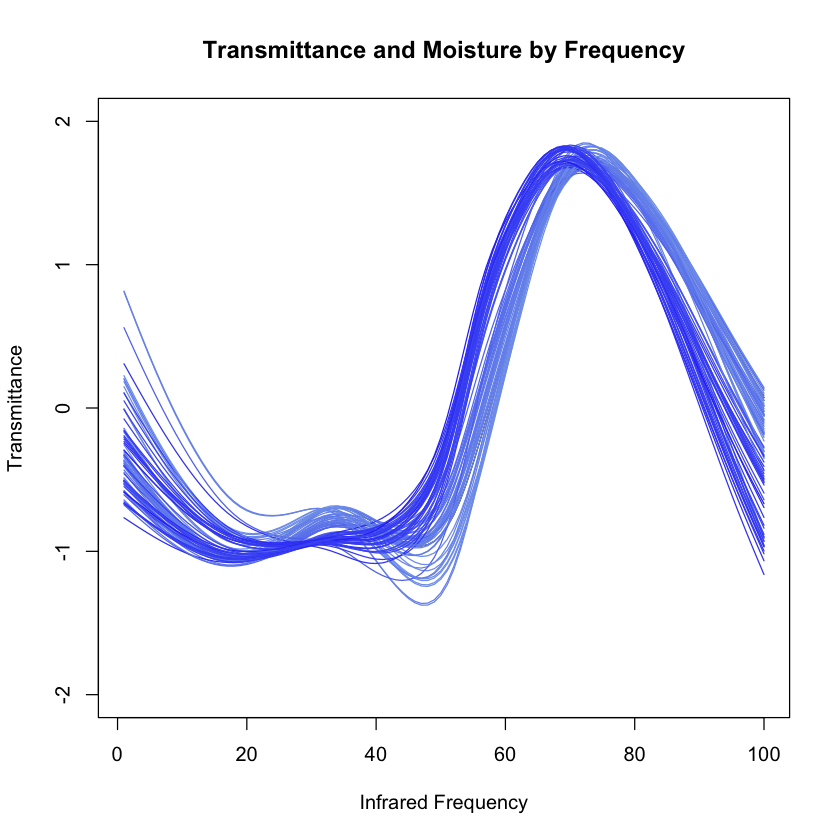

In [5]:
x= 1:100
y = scale(t.wheat[,1][-1])

gradient <- colorRampPalette(c("lightblue", "blue"))

smoothingSpline = smooth.spline(x, y, spar=0.35)
plot(x,y, pch="", ylim = c(-2, 2), xlab='Infrared Frequency', ylab='Transmittance', 
    main='Transmittance and Moisture by Frequency')
lines(smoothingSpline)

for (i in 1:79){
    x= 1:100
    y = scale(t.wheat[,i][-1])
    smoothingSpline = smooth.spline(x, y, spar=0.35)
    points(x,y, pch="")
    lines(smoothingSpline, col=gradient(55)[wheat[i, 1]])

}

In [6]:
# Performing PCR with 10 components using pls package. 

smp_size <- floor(0.75 * nrow(wheat))

set.seed(13)
train_ind <- sample(seq_len(nrow(wheat)), size = smp_size)

train <- wheat[train_ind, ]
test <- wheat[-train_ind, ]

In [7]:
pcr.fit=pcr(water~., data=train, scale=TRUE, ncomp=10)

In [8]:
# Summary
summary(pcr.fit)

Data: 	X dimension: 59 100 
	Y dimension: 59 1
Fit method: svdpc
Number of components considered: 10
TRAINING: % variance explained
       1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X        97.49    99.21    99.95   100.00   100.00   100.00   100.00   100.00
water     7.67    37.64    94.04    94.21    94.24    95.55    95.71    95.98
       9 comps  10 comps
X       100.00    100.00
water    96.19     96.25


In [9]:
# Compute the regression coefficients
coef.package = coef(pcr.fit)[1:10]

In [10]:
# the predicted values
pcr.pred = predict(pcr.fit,test,ncomp=10)

In [11]:
# and the residuals.
MSEP(pcr.fit)
mse.package = mean((pcr.pred - test[,1]))^2
"mse"
mse.package

(Intercept)      1 comps      2 comps      3 comps      4 comps      5 comps  
     52.010       48.021       32.433        3.098        3.012        2.997  
    6 comps      7 comps      8 comps      9 comps     10 comps  
      2.316        2.231        2.089        1.981        1.953  

[1] "mse"

[1] 0.2897633

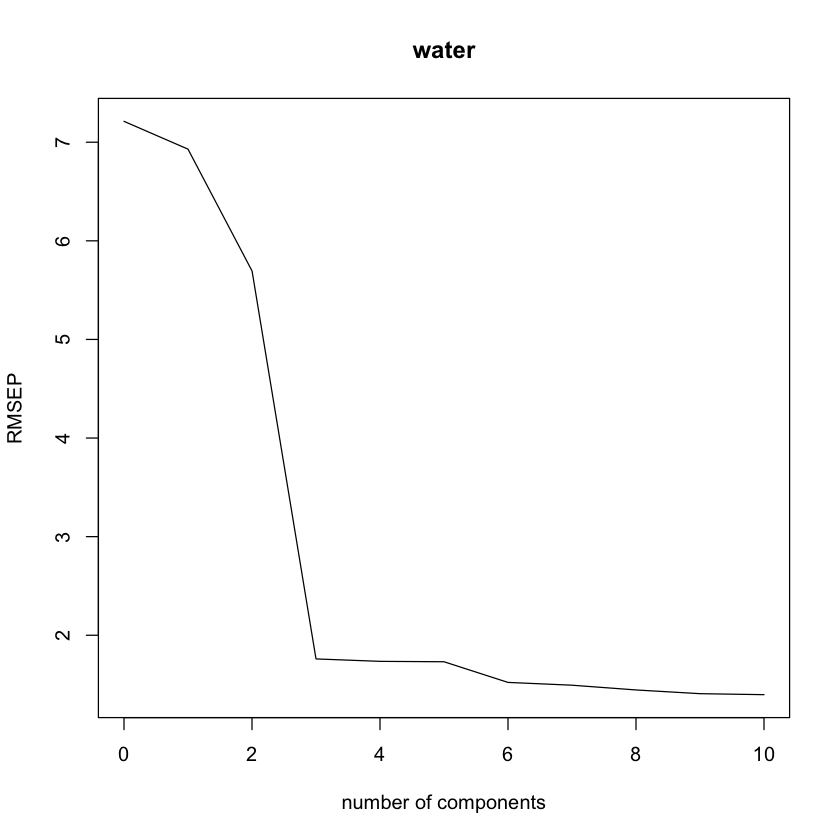

In [12]:
# We can see that 3 Components seem to explain the variance sufficiently.
validationplot(pcr.fit)

In [13]:
# Instead of using the convenient R functions for PCR in the R package pls,
# create the principal components  𝑍1,…,𝑍10  manually using the base R 
# function prcomp(). Use them to calculate the coefficients, 
# the predicted values, and the residuals. 
# Verify your coding by comparing them to your results from b.).

In [14]:
# Get Principal Components
pr.train= prcomp(train[,2:101], scale=TRUE)

# Get the first 10 rotations 
pr.10 = pr.train$rotation[,1:10]

# Apply rotations to instances in training and test sets
pc.train.data = as.data.frame( as.matrix(train[,2:101])%*%as.matrix(pr.10))
pc.test.data = as.data.frame( as.matrix(test[,2:101])%*%as.matrix(pr.10))

# Add labels
pc.train.data = cbind(water = train$water, pc.train.data)
pc.test.data = cbind(water = test$water, pc.test.data)

# train linear model using principal compnents as predictors 
my.pcr = lm(water~., data=pc.train.data)
summary(my.pcr)


Call:
lm(formula = water ~ ., data = pc.train.data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3311 -0.7006 -0.0302  0.4012  7.8202 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   14.9023     6.7737   2.200   0.0327 *  
PC1           -0.8850     0.6959  -1.272   0.2096    
PC2          -32.2753     3.9144  -8.245 9.40e-11 ***
PC3           55.1731     5.2403  10.529 4.57e-14 ***
PC4            1.7350    10.1188   0.171   0.8646    
PC5            1.9420    32.3705   0.060   0.9524    
PC6          400.2981    90.7546   4.411 5.80e-05 ***
PC7         -167.9835   121.2260  -1.386   0.1722    
PC8         -369.6426   204.2156  -1.810   0.0765 .  
PC9         -544.4877   321.8507  -1.692   0.0972 .  
PC10        -517.6979   628.9324  -0.823   0.4145    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.55 on 48 degrees of freedom
Multiple R-squared:  0.9624,	Adjusted R-squared:  0.9546 
F-statist

In [15]:
# Test model
my.pcr.fit = predict(my.pcr, newdata=pc.test.data)
summary(my.pcr.fit)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  16.83   21.28   31.31   28.88   34.71   40.38 

In [16]:
# The model I built is roughly 0.2 %
# less accurate than the one in the package in this case. 
mse.me = mean((my.pcr.fit - test[,1]))^2
mse.me/mse.package

[1] 1.001601

In [17]:
# Prediction error is estimated through cross validation, which provides insight into a 
# model's ability to generalize. This estimation is determined by 
# approximations of both the model's bias and variance.

# In our case, predicted error values are remarkably low, indicating that 
# PCR with 10 components is flexible enough to model our desired function, 
# whilst being biased enough to ignore noise in the data.  

MSEP(pcr.fit)

(Intercept)      1 comps      2 comps      3 comps      4 comps      5 comps  
     52.010       48.021       32.433        3.098        3.012        2.997  
    6 comps      7 comps      8 comps      9 comps     10 comps  
      2.316        2.231        2.089        1.981        1.953  

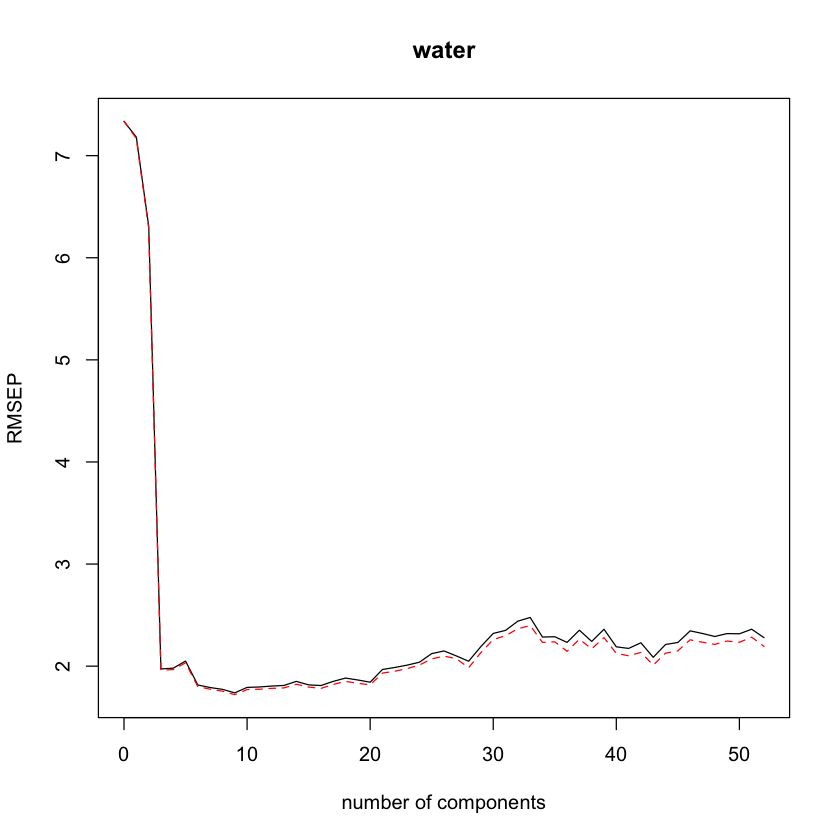

In [18]:
# Here I use cross-validation to estimate the accuracy of models with  0,1,2,…  components. 
# Plot the estimated prediction error versus the number of components and decide on 
# how many components you want to include in the model. 

cv = pcr(water~., data=train, scale=TRUE, validation = "CV")
plot(RMSEP(cv))

In [19]:
# Discuss your choice by providing the estimated prediction error 
# for your chosen model size and describing 
# the most important components for predicting the response.

pcr.3 =pcr(water~., data=train, scale=TRUE, ncomp=20)


MSEP(pcr.3)

(Intercept)      1 comps      2 comps      3 comps      4 comps      5 comps  
     52.010       48.021       32.433        3.098        3.012        2.997  
    6 comps      7 comps      8 comps      9 comps     10 comps     11 comps  
      2.316        2.231        2.089        1.981        1.953        1.949  
   12 comps     13 comps     14 comps     15 comps     16 comps     17 comps  
      1.932        1.916        1.837        1.835        1.758        1.757  
   18 comps     19 comps     20 comps  
      1.744        1.702        1.702  

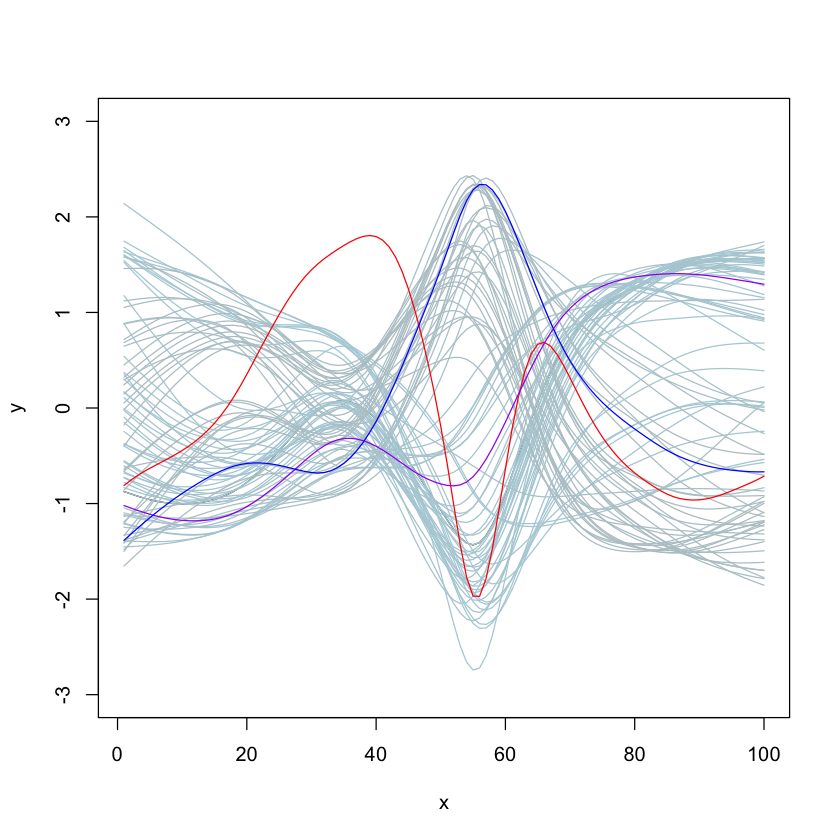

In [33]:
y = scale(s.t.wheat[,1][-1])

gradient <- colorRampPalette(c("lightblue", "grey"))

smoothingSpline = smooth.spline(x, y, spar=0.35)
plot(x,y, pch="", ylim = c(-3, 3))
lines(smoothingSpline)

for (i in 1:79){
    x= 1:100
    y = scale(s.t.wheat[,i][-1])
    smoothingSpline = smooth.spline(x, y, spar=0.35)
    points(x,y, pch="")
    lines(smoothingSpline, col=gradient(55)[wheat[i, 1]])

}
pc1.spline = smooth.spline(x, scale(pcr.3$loadings[,1]), spar=0.1)
lines(x, scale(pcr.3$loadings[,1]), col='red')
pc2.spline = smooth.spline(x, scale(pcr.3$loadings[,2]), spar=0.1)
lines(pc2.spline, col='purple')
pc3.spline = smooth.spline(x, scale(pcr.3$loadings[,3]), spar=0.1)
lines(pc3.spline, col='blue')

## A similair colored graph to the one in 2.a is plotted below, however columns (frequencies) are scaled. 
## I have also fit splines to scaled versions of the 3 first principle components. 

## Looking at the loadings (eigenvectors) we notice that the first principal component (red)
## draws most of its information from those frequencies in the spectrum that I mentioned in 
## part 2.a. Here most of the change that occurs with respect to an increase in water values
## occurs in two intervals, X62-X72 where frequncies tend to shift to lower values, and 
## X17~X49, where they tend to flatten out. 

## The 2nd principal component (purple) covers the lower and upper frequencies, with patterns in the 
## lower end being less interpretable than those in the higher end. 

## Finally, the 3rd principal compnent (blue) seems to concern itself mostly with 
## frequencies in the range X48-X66, where some more obvious shifting takes place. 
## PC3 also seems to help PC2 in 'decoding' the lower frequencies. 


In [32]:
# Here I use LOOCV of PCR with 10 components using the R function train in the R package caret. 

library(caret)
method = "pcr"
trControl = trainControl(method = "LOOCV")


wheat.loocv = train(water~., data=train, trControl=trControl, method=method)

print(wheat.loocv)

# Fortunately, this method also found 3 components to be sufficient. 


Principal Component Analysis 

 59 samples
100 predictors

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 58, 58, 58, 58, 58, 58, ... 
Resampling results across tuning parameters:

  ncomp  RMSE      Rsquared    MAE     
  1      7.082305  0.04205137  6.185346
  2      6.063618  0.29783869  5.008134
  3      1.903150  0.93041415  1.277105

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was ncomp = 3.
